## 模型選擇
問題：
- 不論是傳統機器學習還是深度學習都有許多的模型可以選擇，針對一個專案要進行時，開始建立模型除了已對產業知識相當了解，知道有哪一些模型會表現得好之外，我們還可能過什麼方式去選擇模型?
- 將可能的選擇(當然要在成本、預算考量下)，全部跑過一次，直接比較表現嗎? 這可能會發生 **剛好** 模型表現不錯，在統計學，你可以說選到偏頗的樣本，錯誤的將其看成該模型的總體表現，這就可能會產生最開始就選擇一個表現不會太好的模型，從而導致專案效果不如預期。

解決方法:
- 融入統計學觀念、視覺化方法，將模型表現經過k-fold，產出多次表現，進而使用統計檢定/視覺化方法幫助觀察哪一個適合當作模型的baseline 選擇。
    - note: 要注意的是，這樣拆解產出的效果，是沒有符合部分檢定的假設，但還是可以當做初步的參考! 這部分詳細討論可以參考 [medium](https://towardsdatascience.com/statistical-tests-for-comparing-classification-algorithms-ac1804e79bb7) 
     
     

In [1]:
# !pip install lightgbm
# !pip install xgboost

In [2]:
# data
import numpy as np
import pandas as pd

# model

from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# split data
from sklearn import model_selection

# data transform
from sklearn import preprocessing

# metrics
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway
from scipy.stats import ttest_1samp, ttest_rel

# vis
import matplotlib.pyplot as plt

# time
import time

import warnings
warnings.filterwarnings("ignore")

## 步驟
1. 建立想測試模型的list
2. [K-fold 或者其他切分方式](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
3. 訓練測試模型並預測結果
    - [scoring 參考](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)
4. 統計檢定 / 視覺化 選擇出baseline模型

In [3]:
def create_model_list():
    models = []
    models.append(('Lasso', linear_model.Lasso()))
    models.append(('Ridge', linear_model.Ridge()))
    models.append(('EN', linear_model.ElasticNet()))
    models.append(('RandomForest', ensemble.RandomForestRegressor()))
    models.append(('KNR', neighbors.KNeighborsRegressor()))
    models.append(('DT', tree.DecisionTreeRegressor()))
    models.append(('ET', tree.ExtraTreeRegressor()))
    models.append(('LGBM', LGBMRegressor()))
    models.append(('XGB', XGBRegressor()))
    models.append(('GBM', ensemble.GradientBoostingRegressor()))
    models.append(("SVR", svm.LinearSVR()))
    return models


def train_models(X, y, models: list, n_splits: int, shuffle: bool, metric: str, seed: int=222) -> dict:
    results = []
    seed = seed if shuffle else None
    
    for m_name, model in models:
        print(f'模型: {m_name}: 訓練中...')
        t = time.time()
        
        cv = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed)
        cv_results = model_selection.cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=cv, n_jobs=-1)
        
        time_cost = time.time()-t
        results.append((m_name, cv_results, time_cost))
        print(f"模型表現 {metric}: \n 平均: {cv_results.mean()}\n 標準差: {cv_results.std()} \n 花費時間: {time_cost}")
        print('-'*30)
    return results


def visualize_model_performance(results: list):
    # Compare our models in a box plot
    
    fig = plt.figure(figsize=(12,7))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([e[1] for e in results])
    ax.set_xticklabels([e[0] for e in results])
    plt.show()

(506, 13) (506,)
模型: Lasso: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -40.605845627892634
 標準差: 22.670785633633592 
 花費時間: 12.35930323600769
------------------------------
模型: Ridge: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -36.84237612073217
 標準差: 23.078769874783895 
 花費時間: 2.235053300857544
------------------------------
模型: EN: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -39.47156340421474
 標準差: 19.84183457184994 
 花費時間: 1.699852705001831
------------------------------
模型: RandomForest: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -22.112075007513088
 標準差: 13.579350329637716 
 花費時間: 0.46905040740966797
------------------------------
模型: KNR: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -29.55021237041351
 標準差: 10.895678740023865 
 花費時間: 0.0890054702758789
------------------------------
模型: DT: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -38.789512327703356
 標準差: 18.685663598278833 
 花費時間: 0.12195825576782227
------------------------------
模型: ET: 訓練中...
模型表現 neg_mean_squared_error: 
 平均: -34

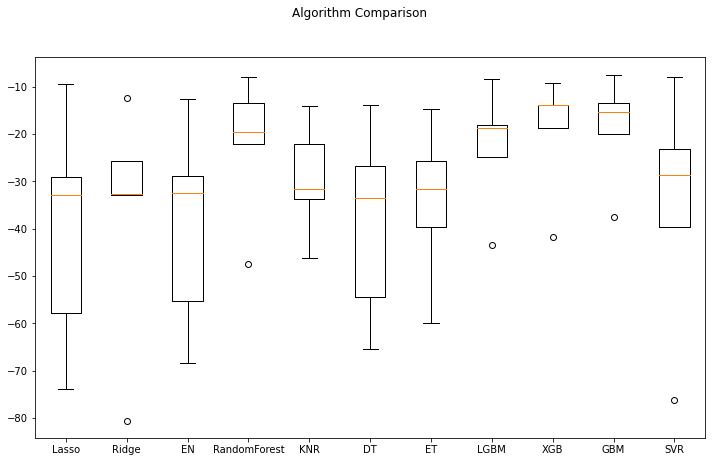

In [4]:
# 簡單使用內建資料集
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
print(X.shape, y.shape)

# 標準化
# 假定為訓練資料
X = preprocessing.StandardScaler().fit_transform(X)

# 步驟
models = create_model_list()
results = train_models(X, y, models, 5, False, 'neg_mean_squared_error')
visualize_model_performance(results)

機器學習問題檢定之間比較可參考 [機器學習模型真的準嗎？從虛無假設檢定來檢驗模型成效](https://aiec.nccu.edu.tw/ai-column/28)

### 檢定比較
1. 模型與baseline 可以用單一樣本t檢定
2. 兩模型之間可以用相依樣本t檢定 or 獨立樣本t檢定
3. 多模型互比可以用 ANOVA + scipy.stats.tukey_hsd

In [5]:
# 1. 模型與baseline 可以用獨立樣本t檢定

def test_superior_baseline(X, y, model, baseline, alpha):
    """
        交叉驗證模型是否優於 baseline
    """
    model_metrics = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')
    print(model_metrics)
    result = ttest_1samp(a=model_metrics, popmean=baseline)
    
    print(result)
    return result.pvalue < alpha

test_superior_baseline(X, y, XGBRegressor(), -45, 0.05)

[ -8.58595677  -6.83832583  -9.8084139  -23.30192116 -14.42698581
 -22.46244808  -6.65083924 -89.29708857 -29.50884717 -17.66007498]
Ttest_1sampResult(statistic=2.8458470233011477, pvalue=0.019218945572683867)


True

In [6]:
# 2. 兩模型之間可以用相依樣本t檢定 or 獨立樣本t檢定
# 用lasso, XGBoost

lasso_idx = 0
xbg_idx = 8

ttest_rel(results[lasso_idx][1], results[xbg_idx][1])

Ttest_relResult(statistic=-2.783536007507163, pvalue=0.04963873816568362)

In [8]:
# 3. 多模型互比可以用 ANOVA + scipy.stats.tukey_hsd


fvalue, pvalue = f_oneway(*[e[1] for e in results])
print(f"f-統計量: {fvalue}, p-value: {pvalue}")

endog = np.concatenate([e[1] for e in results], axis=0)
groups = np.concatenate([[e[0]]*len(e[1]) for e in results], axis=0)

m_comp = pairwise_tukeyhsd(endog=endog, groups=groups, alpha=0.05)
print(m_comp)

f-統計量: 0.9819013972472941, p-value: 0.47274716135684636
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
          DT           EN  -0.6821    1.0 -41.7492 40.3851  False
          DT           ET   4.4444    1.0 -36.6228 45.5115  False
          DT          GBM   20.049 0.8486 -21.0182 61.1161  False
          DT          KNR   9.2393 0.9994 -31.8279 50.3065  False
          DT         LGBM  16.0517 0.9589 -25.0154 57.1189  False
          DT        Lasso  -1.8163    1.0 -42.8835 39.2508  False
          DT RandomForest  16.6774 0.9474 -24.3897 57.7446  False
          DT        Ridge   1.9471    1.0   -39.12 43.0143  False
          DT          SVR   3.6144    1.0 -37.4528 44.6815  False
          DT          XGB  19.3222 0.8754  -21.745 60.3894  False
          EN           ET   5.1264    1.0 -35.9407 46.1936  False
          EN        

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

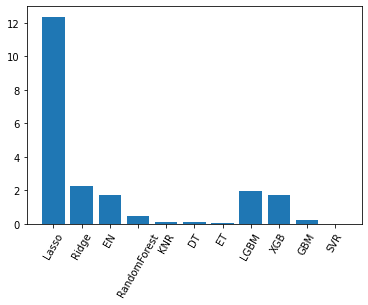

In [9]:
## 訓練速度上比較, 當然還可以比較預測速度等等

plt.bar([e[0] for e in results], [e[2] for e in results])
plt.xticks(rotation=60)

## 結論
- 根據視覺化結果tree-based模型表現得比較穩定，可以當作基礎模型去使用。
- 若不考慮模型速度，也可以使用emsemble方法挑多個baseline去進一步增進最後的效果。